# `train_test_split()`

In [1]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Import data, take `TAX`, `CRIM`, and `PTRATIO` and assign to `X`. Assign target to `y`.

In [3]:
data = load_boston()

# print(data.DESCR)

In [4]:
boston = pd.DataFrame(data.data, columns=data.feature_names)
X = boston[['TAX', 'CRIM', 'PTRATIO']].copy()
boston_y = pd.DataFrame(data.target)

print(X.head())
print(boston_y.head())

     TAX     CRIM  PTRATIO
0  296.0  0.00632     15.3
1  242.0  0.02731     17.8
2  242.0  0.02729     17.8
3  222.0  0.03237     18.7
4  222.0  0.06905     18.7
      0
0  24.0
1  21.6
2  34.7
3  33.4
4  36.2


Create `X_train, X_test, y_train, y_test` using train-test split with a 33% holdout

In [9]:
X_train, X_test, y_train, y_test = train_test_split(boston, boston_y, test_size=0.33)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(339, 13) (167, 13) (339, 1) (167, 1)


Fit a linear regression to the **training** set (`X_train` and `y_train`) and look at the $R^2$ score **on the training set**

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))

0.729421460728


Why is the $R^2$ using the **training set** misleading?

**Without refitting the data**, look at the $R^2$ score on the **test set** (`X_test` and `y_test`)

In [11]:
print(lr.score(X_test, y_test))

0.756668608784


Why is this a more accurate measure of how well our linear regression of `TAX`, `CRIM`, and `PTRATIO` on `MDEV`? 

## Try it out!

Import the `datasets/salary.csv` dataset. This dataset records the salary of academics and measures the following features:

- sx = Sex, coded 1 for female and 0 for male
- rk = Rank, coded
  - 1 for assistant professor,
  - 2 for associate professor, and
  - 3 for full professor
- yr = Number of years in current rank
- dg = Highest degree, coded 1 if doctorate, 0 if masters
- yd = Number of years since highest degree was earned
- sl = Academic year salary, in dollars.

Import the salary data, assign the `yr` and `yd` columns to a variable named `X`, then assign `sl` to a variable named `y`

In [19]:
salary = pd.read_csv('./datasets/salary.csv')
salary.head(2)

,sx,rk,yr,dg,yd,sl
0,male,full,25,doctorate,35,36350
1,male,full,13,doctorate,22,35350


In [26]:
salary.head(9)

,sx,rk,yr,dg,yd,sl
0,0,3,25,1,35,36350
1,0,3,13,1,22,35350
2,0,3,10,1,23,28200
3,1,3,7,1,27,26775
4,0,3,19,0,30,33696
5,0,3,16,1,21,28516
6,1,3,0,0,32,24900
7,0,3,16,1,18,31909
8,0,3,13,0,30,31850


In [25]:
salary['rk'] = salary['rk'].map({'assistant': 1, 'associate': 2, 'full': 3})
salary['dg'] = salary['dg'].map({'doctorate': 1, 'masters': 0})
salary['sx'] = salary['sx'].map({'male': 0, 'female': 1})

In [27]:
salary.dtypes

sx    int64
rk    int64
yr    int64
dg    int64
yd    int64
sl    int64
dtype: object

Use `train_test_split()` to create a training set and a test set, split 50/50

In [28]:
X = salary.iloc[:,:-1]
y = salary.iloc[:,-1]

In [33]:
print('X shape: {}, y shape:{}'.format(X.shape, y.shape))

X shape: (52, 5), y shape:(52,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34, 5) (18, 5) (34,) (18,)


Train a linear regression using the training set. What does the $R^2$ look like for the training set? What does the $R^2$ look like for the test set? Which is higher? Which is a more accurate number? Why?

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
lm = LinearRegression()
model = lm.fit(X_train, y_train)
predictions  =  model.predict(X_test)
score        =  model.score(X_test, y_test)

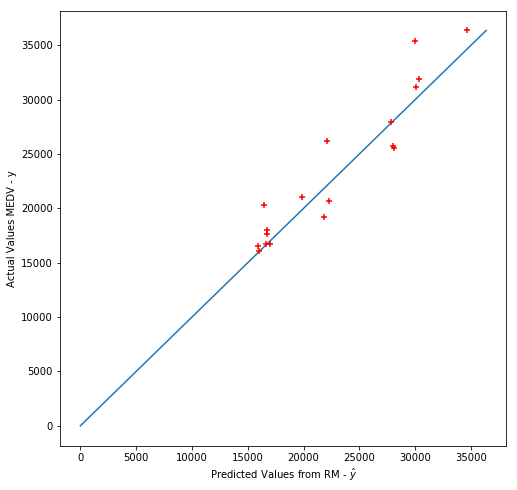

score:  0.879955251945


In [37]:
# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from RM - $\hat{y}$")
plt.ylabel("Actual Values MEDV - y")

plt.plot([0, np.max(y_test)], [0, np.max(y_test)])

plt.show()

print("score: ", score)

# `cross_val_score()` and `cross_val_predict()`

Let's use `cross_val_score()` and `cross_val_predict()` to do cross-validation and to take a quick look at each fold.

Using the boston data, let's pick `CRIM`, `ZN`, and `INDUS` for our predictors and assign them to `X`

In [ ]:
X = boston[['CRIM', 'ZN', 'INDUS']].copy()
print(X.head())
print(boston_y.head())

Use `cross_val_score()` and five-fold cross-validation to see the $R^2$ for each of the folds compared to the test set for that fold:

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict

lr = LinearRegression()

print(cross_val_score(lr, X, boston_y, cv=5))

What do the low $R^2$ scores mean? If they were there, what does a **negative** $R^2$ show?

We may also want to see an overall score for these folds. Typically, we will take the average $R^2$ across each fold:

In [ ]:
scores = cross_val_score(lr, X, boston_y, cv=5)
print(scores.mean())

Use `cross_val_predict()` and assign the predicted values for each test fold to an object called `predictions`. How many predictions should we have in total?

In [ ]:
predictions = cross_val_predict(lr, X, boston_y, cv=5)

`cross_val_predict()` lets us use the predictions from each fold to look at metrics that are important but not part of `LinearRegression()`'s `.score()` method, such as the mean squared error. The mean squared error is the average difference between the true y and the predicted y:

$$ \text{Mean Squared Error} = \frac{\sum(y_i - \hat{y}_i)^2}{n} $$

We will import sklearn's `mean_squared_error()` function which takes in a true y and a predicted y and outputs the MSE

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(boston_y, predictions)

## Try it out!

Using the Boston housing data above, try a different set of columns -- does the $R^2$ on the folds shown by `cross_val_score()` improve? What about the MSE using the predictions output by `cross_val_predict()`?

# `KFold`

Sklearn also lets us manually create folds, which we can then call other options on. This is helpful if we want to do more advanced work on each of those folds. 

In the following example, we will fit a linear regression using every column in the Boston housing data and validating its efficacy using 5-fold cross-validation. For each fold, I will calculate the $R^2$ and the MSE -- this would be difficult to do without using `KFolds` to manually split up the data.

For ease of indexing, I am converting `X` into a `numpy` array using the `.values` attribute

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
X = boston.copy().values
boston_y = boston_y.values

print(X.shape, boston_y.shape)

Instantiate a `KFold` object with 5 folds

In [ ]:
kfolds = KFold(5)

`KFold` will take in one or two data collections and return back a set of paired indices for the folds in question:

In [ ]:
for training_index, test_index in kfolds.split(X, boston_y):
    print('training: ', training_index[0:5], '...', training_index[-6:-1], 
          '\ntest: ', test_index[0:5], '...', test_index[-6:-1], '\n')

We will use these indices to manually split up `X` and `boston_y`:

In [ ]:
counter = 0
for training_index, test_index in kfolds.split(X, boston_y):
    x_train = X[training_index]
    x_test = X[test_index]
    y_train = boston_y[training_index]
    y_test = boston_y[test_index]
    print('fold', counter, '-', x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    counter += 1 

We then feed these folds into `LinearRegression()` to fit it to a given fold and then use `.score()` and `mean_squared_error()` to look at the fit on the test set in each fold:

In [ ]:
counter = 0
lr = LinearRegression()
for training_index, test_index in kfolds.split(X, boston_y):
    x_train = X[training_index]
    x_test = X[test_index]
    y_train = boston_y[training_index]
    y_test = boston_y[test_index]
    lr.fit(x_train, y_train)
    r2_score = lr.score(x_test, y_test)
    fold_predictions = lr.predict(x_test)
    mse_score = mean_squared_error(y_test, fold_predictions)
    print('Fold', counter, '- r^2 score:', r2_score, 'mse:', mse_score)
    counter += 1

By using `KFold` we are able to access the folds _as they are created_ and can learn more about how well each fold does using different statistics. 

**Discussion Questions**:

1. Why might we want to look at different goodness of fit metrics during the cross-validation process?
2. It looks like our $R^2$ changes pretty frequently but our `mse` is not particularly volatile in this process. Have we made a good modeling choice by including every column in Boston? Why or why not? 